# Data Visualization

There are two main packages that we will use for visualization in Python: [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/), which is based on matplotlib.  First, let's import these.  It is customary to import the pyplot module from matplotlib, since it contains most of the important plotting functions:

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## Let's think through a visualization

Principles we want to keep in mind: 

* Show the data without distortion
* Use color, shape, and location to encourage comparisons
* Minimize visual clutter (maximize your information to ink ratio)

The two questions you want to ask yourself before getting started are:

* What type of variable(s) am I plotting?
* What comparison do I want to make salient for the viewer (possibly myself)?

Figuring out *how* to highlight a comparison and include relevant variables usually benefits from sketching the plot out first.

# Plotting the distribution of a single variable

One of the most common uses of plotting is to plot the *distribution* of the data --- which you can think of as the *shape* of the data.  There are various ways to do this, but one of the most common is known as a *histogram*, which plots the number of observations that fall into specific bins. We can plot a histogram using the `plt.hist()` function from matplotlib.  As an example, let's look at the distribution of ages in the NHANES dataset.  First we need to load the data:

In [32]:
from nhanes.load import load_NHANES_data
nhanes_data = load_NHANES_data()

/Users/poldrack/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (142) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Then we can plot the histogram:

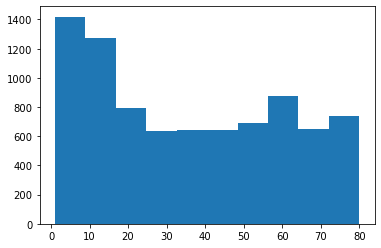

In [33]:
age_histogram = plt.hist(nhanes_data['AgeInYearsAtScreening'])

You can see from this plot that the `plt.hist()` function has binned together individuals across several years; That's because we let it automatically determine the size of the bins. Let's say that instead we want to bin each year separately.  We can do this using the `bins` argument to `plt.hist`. Because this argument takes a list of bins, we need to create a list that spans from the youngest to the oldest age.  We can do this using the `np.arange()` function from numpy, which generates a list of numbers that span a particular range. In this case, we need to span from the youngest to the oldest value, which are equivalent to the minimum and maximum values which we can obtain using the `.min()` and `.max()` operators; because Python starts at zero, we need to add one to the maximum in order to get the bins to cover the entire range:

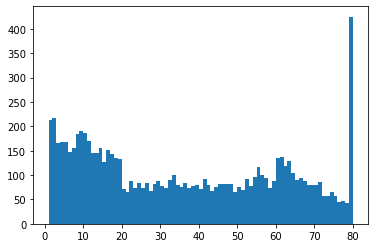

In [34]:
bins = np.arange(nhanes_data['AgeInYearsAtScreening'].min(), nhanes_data['AgeInYearsAtScreening'].max() + 1)
age_histogram_1year_bins = plt.hist(nhanes_data['AgeInYearsAtScreening'], bins=bins)

Sometimes it's more useful to look at the density rather than the counts, which we can do by setting `density=True` in our call to the histogram function:

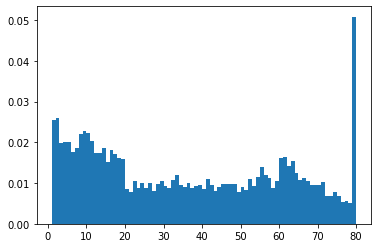

In [35]:
age_density_1year_bins = plt.hist(nhanes_data['AgeInYearsAtScreening'], bins=bins, density=True)

Now we see the proportion of individuals that fall into each age bin.  Why do you think there are so many eighty-year-olds in the dataset?  Have a look at the [documentation for the Age question](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.htm#RIDAGEYR) and see if you can figure it out.

#### Bar vs. line plots

The histograms above are an example of *bar plots* where each number is represented by a bar. We could also plot the distribution using a line instead.  One reason to do this is that we can make the line a bit *smoother* than the actual data.  For example, here are the histogram data from above, plotted as a line:

In [ ]:
plt.plot(age_density_1year_bins[1][1:], age_density_1year_bins[0])

Here we have taken advantage of the fact that the output of our histogram command above contains both the bins (in its [1] position) and the histogram values (in its [0]) position.  Why do we include `[1:]` after the bins variable?  This is because the bins include both the upper and lower edges of the bin, which means that there is one more bin value than there are average values.  Adding `[1:]` is equivalent to saying "start with the second bin" which is equivalent to using the top edges of each bin for our X axis.

Now let's plot a smoothed version of the histogram, using the `sns.distplot()` function from the seaborn library.  

In [ ]:
sns.distplot(nhanes_data['AgeInYearsAtScreening'], bins=bins)

You can see that the line is now much smoother (less bumpy) than the one above.  It generally follows the overall shape of the data pretty closely, but you can also see that it mostly hides the large bump at 80 years.  It's always important to keep in mind that anything we do to the data has the potential to distort their message.

# Plots with two variables

Another common use of visualization is to examine the relationship betwen two variables.  For example, let's say that we wanted to plot average height as a function of age in the NHANES dataset.  We would first summarize the data to obtain the average height for each age:

In [36]:
mean_height_by_age = nhanes_data.groupby('AgeInYearsAtScreening')['StandingHeightCm'].mean()

Here we use a method called `.groupby()` along with a builtin in method for computing the average of a variable in a dataframe (`.mean()`).  This returns a single average height value for all of the individuals in each age group, which we can then plot.  While we are at it, we will add descriptive labels to the X and Y axes, which is always a good idea:

Text(0, 0.5, 'Standing Height (cm)')

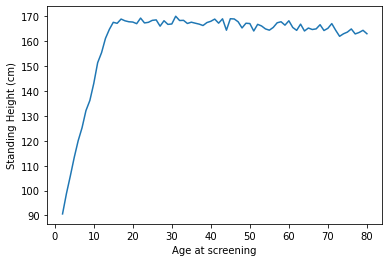

In [37]:
plt.plot(mean_height_by_age.index, mean_height_by_age)
plt.xlabel('Age at screening')
plt.ylabel('Standing Height (cm)')

As expected, people get taller up to about age 18, and then then slowly shrink over time.  Since we know that men and women differ in their height, we can also plot their average heights separately. We could do this using the matplot plotting function, but it's actually easier to do using the `sns.lineplot()` function from the seaborn library that we imported above.  We simply give it the X and Y variables that we want to plot as well as the variable that we want to separate (using different colors), and it does the work for us:

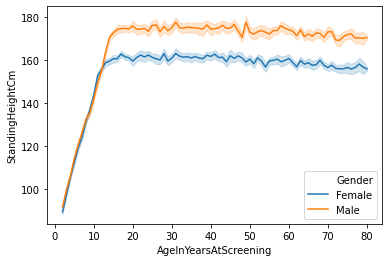

In [38]:
sns.lineplot(x='AgeInYearsAtScreening', y='StandingHeightCm', hue='Gender', data=nhanes_data)

You will notice that the lines have shaded areas around them; these are called *confidence intervals*, and you will learn about them later in the course.  They basically tell us something about the uncertainty around our estimates of the average.

### Plotting dispersion

An important job of statistical visualization is to show us the variability, or *dispersion*, of our data.  We have already see how to do this using histograms; now let's look at how we can compare distributions.

Let's start with a simple example: Comparing the height of adult men and women in the NHANES sample.  One commonly used plot is the *box plot* (sometimes known as a *box and whiskers plot*).  This form of plot uses quartiles to give us a sense of spread. The thickest line, somewhere inside the box, represents the *median*. The upper and lower bounds of the box (the *hinges*) are the first and third quartiles (can you use them to approximate the interquartile range?). The lines extending from the hinges are the remaining data points, excluding **outliers**, which are plotted as individual points. 

In [ ]:
adult_nhanes_data = nhanes_data.query('AgeInYearsAtScreening > 17')
sns.boxplot(x='Gender', y='StandingHeightCm', data=adult_nhanes_data)

This tells us that the median male is taller than 75% of all of the females in the sample.

Another type of plot that is commonly used is the *violin plot*, which shows the shape of the entire distribution:

sns.violinplot(x='Gender', y='StandingHeightCm', data=adult_nhanes_data)

### Scatter plot

When we have multiple *continuous* variables, we can use points to plot each variable on an axis. This is known as a **scatter plot**. As an example, let's look at the blood pressure readings taken in the NHANES study.  Each individual has their blood pressure taken three times. Here we will plot the first reading against the second reading, using a scatter plot. We will also add a line showing where the x axis is equal to the y axis, which makes it easier to see how the two variables are related to each other.

In [ ]:
sns.scatterplot(x='SystolicBloodPres1StRdgMmHg',
                y='SystolicBloodPres2NdRdgMmHg',
                data=adult_nhanes_data)
plt.plot([adult_nhanes_data['SystolicBloodPres1StRdgMmHg'].min(),
          adult_nhanes_data['SystolicBloodPres1StRdgMmHg'].max()],
          [adult_nhanes_data['SystolicBloodPres2NdRdgMmHg'].min(),
          adult_nhanes_data['SystolicBloodPres2NdRdgMmHg'].max()],
          color='k')
plt.xlabel('Systolic BP - First reading')
plt.ylabel('Systolic BP - Second reading')

Here we can see that the two variables are closely related to one another.  We can also see that most of the blue points fall below the black line, which tells us that the second reading is generally somewhat lower than the first reading. 

In this section we will recreate a version of [Figure 4.2](https://statsthinking21.github.io/statsthinking21-core-site/data-visualization.html#anatomy-of-a-plot) from Statistical Thinking in the 21st Century.  

In [ ]:

oring_data = pd.read_csv('data/orings.csv', index_col=0)

ax = sns.lineplot(x='Temperature', y='DamageIndex', data=oring_data, ci=None)
plt.xlabel('Temperature at time of launch')
plt.ylabel('Damage Index')
ax.fill_between([26, 29], 0, 12, 
                facecolor='red', alpha=0.3)
ax.text(27, 1, 'Forecasted temperature on Jan 28', rotation=90)